In [129]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [130]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [131]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [132]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [133]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [134]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


очистка от дубликатов

In [135]:
print(df_train.duplicated().sum())
df_train = df_train.drop_duplicates()
print(df_train.shape[0])

307
386496


In [136]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [137]:
#sentiment = pd.Series(df_train['sentiment'].unique())
#print(sentiment)

In [138]:
df_train['hotel_address'].loc[0:9]

0    Stratton Street Mayfair Westminster Borough Lo...
1    130 134 Southampton Row Camden London WC1B 5AF...
2     151 bis Rue de Rennes 6th arr 75006 Paris France
3    216 Avenue Jean Jaures 19th arr 75019 Paris Fr...
4            Molenwerf 1 1014 AG Amsterdam Netherlands
5                   Via Mecenate 121 20138 Milan Italy
6    97 Cromwell Road Kensington and Chelsea London...
7    Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
8    190 Queen s Gate Kensington and Chelsea London...
9    Holland Park Avenue Kensington and Chelsea Lon...
Name: hotel_address, dtype: object

In [139]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [140]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [141]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [142]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [143]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Признаки positive_review и negative_review
На основе призаков positive_review и negative_review создаем новые используя анализ тональности с помощью библиотеки nltk

In [145]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
sent_analyzer=SentimentIntensityAnalyzer()
def get_sentiment(review):
    sentiment_score = sent_analyzer.polarity_scores(review)['compound']
   # if sentiment_score >= 0.05:
    #    return 'Positive'
    #elif sentiment_score <= -0.05:
    #    return 'Negative'
    #else:
     #   return 'Neutral'
    return sentiment_score

data['sentiment_positive'] = data['positive_review'].apply(get_sentiment)
data['sentiment_negative'] = data['negative_review'].apply(get_sentiment)


[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


Удаляем колонки positive_review и negative_review, так как мы извлекли из них необходимую информацию и для обучения модели они не понадобятся. 

In [146]:
data=data.drop(['positive_review','negative_review'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

Проверяем на пропуски 

In [147]:
data_nul=data.isnull().sum()
print(data_nul)

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
review_total_negative_word_counts                0
total_number_of_reviews                          0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
sentiment_positive                               0
sentiment_negative                               0
dtype: int64


Выведем названия отелей без координат

In [148]:
filtr_lat_hotels=data[data['lat'].isnull()& data['lng'].isnull()]['hotel_name'].unique()
#print(filtr_lat_hotels)
filtr_lat_hotels_list=filtr_lat_hotels.tolist()
print(filtr_lat_hotels_list)




['Hotel Atlanta', 'City Hotel Deutschmeister', 'Holiday Inn Paris Montmartre', 'Fleming s Selection Hotel Wien City', 'Hotel City Central', 'Cordial Theaterhotel Wien', 'NH Collection Barcelona Podium', 'Hotel Daniel Vienna', 'Maison Albar Hotel Paris Op ra Diamond', 'Mercure Paris Gare Montparnasse', 'Hotel Pension Baron am Schottentor', 'Austria Trend Hotel Schloss Wilhelminenberg Wien', 'Renaissance Barcelona Hotel', 'Derag Livinghotel Kaiser Franz Joseph Vienna', 'Roomz Vienna', 'Hotel Park Villa', 'Hotel Advance']


In [149]:
filtr_lat_hotels=data[data['lat'].isnull()& data['lng'].isnull()]['hotel_name'].value_counts()
print(filtr_lat_hotels)


Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: hotel_name, dtype: int64


По словарю заполняем пропуски координатами

In [150]:
coordinates_dict = {
    'Fleming s Selection Hotel Wien City':[48.209095, 16.354568],
    'Hotel City Central':[48.213560, 16.379923],
    'Hotel Atlanta':[48.220310, 16.355880],
    'Maison Albar Hotel Paris Op ra Diamond':[48.875140, 2.323420],
    'Hotel Daniel Vienna':[48.188835, 16.383810],
    'Hotel Pension Baron am Schottentor':[48.216705, 16.359820],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[48.219555, 16.285566],
    'NH Collection Barcelona Podium':[41.391430, 2.177890],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[48.245914, 16.341188],
    'City Hotel Deutschmeister':[48.220856, 16.366642],
    'Holiday Inn Paris Montmartre':[48.888860, 2.333190],
    'Hotel Park Villa':[48.233495, 16.345556],
    'Cordial Theaterhotel Wien':[48.209530, 16.351515],
    'Roomz Vienna':[48.22201, 16.39331],
    'Mercure Paris Gare Montparnasse':[48.839701, 2.323519],
    'Hotel Advance':[41.38322, 2.16295],
    'Renaissance Barcelona Hotel':[41.392430, 2.167500]
}

def fill_coordinates_from_dict(row):
    hotel_name = row['hotel_name']
    
    if hotel_name in coordinates_dict:
        row['lat'] ,row['lng']= coordinates_dict[hotel_name]
        
    return row
# Применяем функцию для заполнения координат из словаря
data = data.apply(fill_coordinates_from_dict, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   review_total_positive_word_counts           515431 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 

Признак hotel_address. При рассмотрении адресов прослеживается закономерность размещения страны в последней ячйке адреса, создадим новый признак страны для дальнейшего кодирования, и удалим столбец адрес. 

In [151]:
address=pd.Series(data['hotel_address'].unique())
print(address)

0                      Via Senigallia 6 20161 Milan Italy
1       Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...
2             Mallorca 251 Eixample 08008 Barcelona Spain
3       Piazza Della Repubblica 17 Central Station 201...
4       Singel 303 309 Amsterdam City Center 1012 WJ A...
                              ...                        
1488    45 Park Lane Westminster Borough London W1K 1P...
1489         6 Avenue Fr miet 16th arr 75016 Paris France
1490    22 avenue de Villiers 17th arr 75017 Paris France
1491       17 rue de Richelieu 1st arr 75001 Paris France
1492         64 Rue Crozatier 12th arr 75012 Paris France
Length: 1493, dtype: object


In [152]:
data['country'] = data['hotel_address'].apply(lambda address: (address.strip().split()[-2] + ' ' + address.strip().split()[-1]) if address.split()[-1] == 'Kingdom' else address.split()[-1])
data['country'].value_counts()
data = data.drop('hotel_address', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   review_date                                 515431 non-null  object 
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   review_total_negative_word_counts           515431 non-null  int64  
 6   total_number_of_reviews                     515431 non-null  int64  
 7   review_total_positive_word_counts           515431 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 9   tags                                        515431 non-null  object 
 

Признак review_date выделим два новых признака день недели и год. Месяц и квартал, по моему мнению, не повлияют на обучение , проверим это в разных версиях.    


In [153]:
data[['review_date','days_since_review']]

,review_date,days_since_review
0,7/21/2017,13 days
1,12/12/2016,234 day
2,11/26/2015,616 day
3,10/17/2015,656 day
4,5/16/2016,444 day
...,...,...
515426,4/19/2017,106 day
515427,2/13/2017,171 day
515428,2/7/2016,543 day
515429,5/21/2017,74 days


In [154]:
# переводим признак в формат даты,формируем новый признак номер недели  и год
data['review_date'] = pd.to_datetime(data['review_date'])
# формируем новые признаки:
data['review_week'] = data['review_date'].apply(
    lambda x: x.isocalendar()[1])
data['review_year'] = data['review_date'].apply(
    lambda x: x.isocalendar()[0])
data[['review_year','review_week']]


,review_year,review_week
0,2017,29
1,2016,50
2,2015,48
3,2015,42
4,2016,20
...,...,...
515426,2017,16
515427,2017,7
515428,2016,5
515429,2017,20



Признаки review_date удаляем.Признак days_since_review переводим в цифровой формат.

In [155]:
data=data.drop(['review_date'],axis=1)
data['days_since_review'] = data['days_since_review'].apply(lambda x:int(x.split()[0]))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   reviewer_nationality                        515431 non-null  object 
 4   review_total_negative_word_counts           515431 non-null  int64  
 5   total_number_of_reviews                     515431 non-null  int64  
 6   review_total_positive_word_counts           515431 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 8   tags                                        515431 non-null  object 
 9   days_since_review                           515431 non-null  int64  
 

In [156]:
data['days_since_review']=data['days_since_review'].apply(lambda x: int(x))

Признак hotel_name по моему мнению не несет полезной информации, его можно удалить

In [157]:
data['hotel_name']

0                                     Hotel Da Vinci
1                                  Urban Lodge Hotel
2         Alexandra Barcelona A DoubleTree by Hilton
3                           Hotel Principe Di Savoia
4                                     Hotel Esther a
                             ...                    
515426                               Hotel Moonlight
515427                 BEST WESTERN PLUS Amedia Wien
515428                       Bloomsbury Palace Hotel
515429                        The Marble Arch London
515430                         The Nadler Kensington
Name: hotel_name, Length: 515431, dtype: object

In [158]:
data=data.drop(['hotel_name'],axis=1)

Признак reviewer_nationality имеет 227 уникальных значений,

До кодирования признака reviewer_nationality  посторим графики для оценки распределения цифровых признаков.  Все признаки имеют не нормальное распределение.

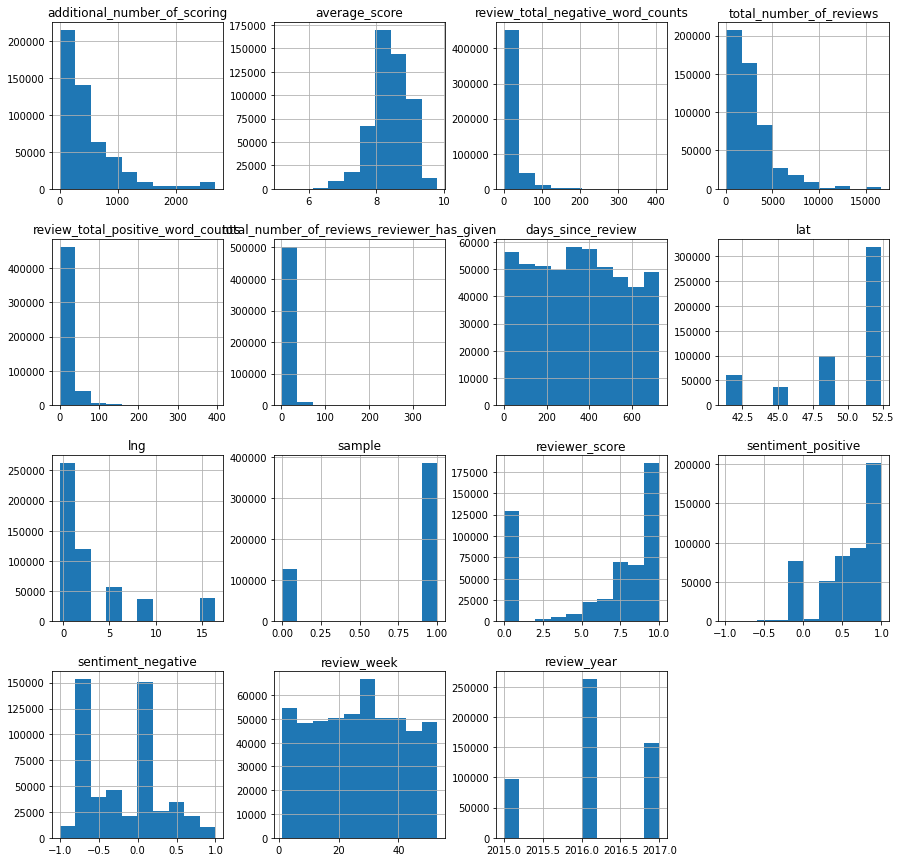

In [159]:
data.hist(figsize = (15,15))
plt.show()

1. Исследуем тепловую карту корреляцми, до кодирования признака reviewer_nationality

сильная корреляция 0,86 между additional_number_of_scoring и total_number_of_reviews и отрицательная между признаками days_since_review и review_year -0.91.В следующей версии удалю, посмотрю как отразится на результат

в этой версии удалю признаки days_since_review  и additional_number_of_scoring, результат стал 0.8784691536992543, был 0.8787945., после введения новых признаков количество ночей из тегов метрика стала 0.8786141734429862- хуже . В этой версии после нормализации мерика 0.8784205657611035 - лучший результат.

In [160]:
data=data.drop(['days_since_review','additional_number_of_scoring'],axis=1)

<AxesSubplot:>

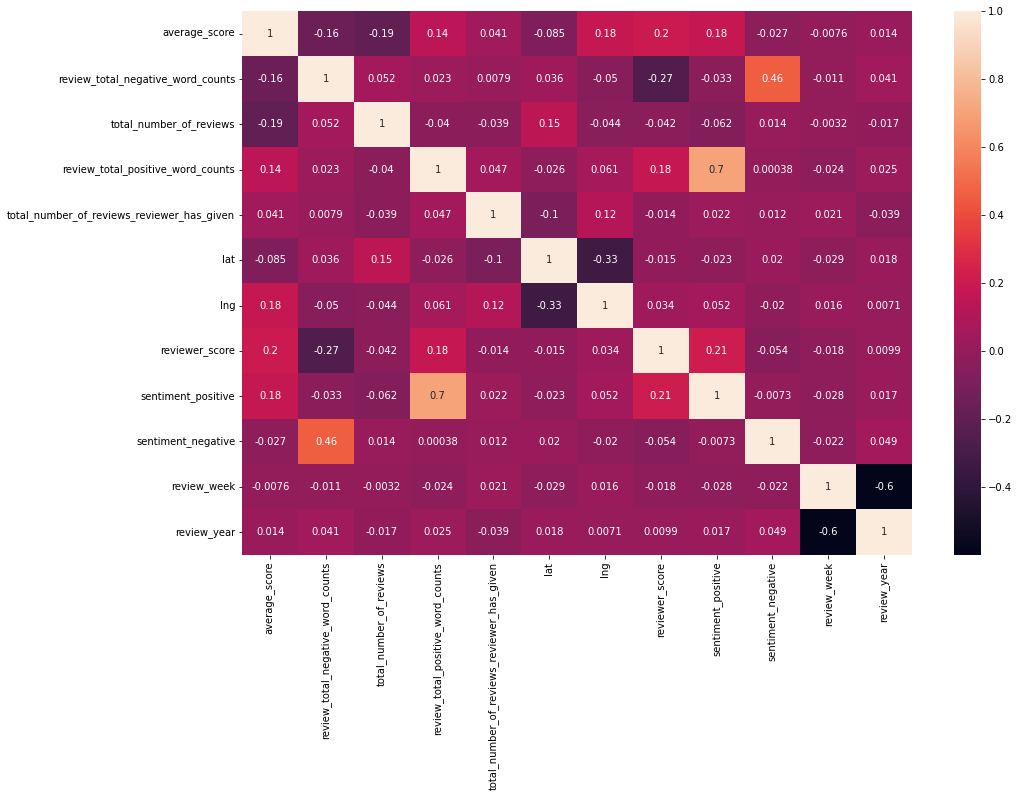

In [161]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(method='spearman'), annot=True)

In [162]:
data['reviewer_nationality'] = data['reviewer_nationality'].astype('category')

Признак reviewer_nationalit, содержит 227 уникальных значений 

In [163]:
data['reviewer_nationality'].nunique()

227

Закодируем столбец с помощью one-hot encoding, такое кодирование подходит, когда нет внутреннего порядка между значениями. 

In [164]:
import category_encoders as ce
bin_encoder = ce.BinaryEncoder(cols = ['reviewer_nationality']) 
df_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, df_bin], axis=1)

In [165]:
#data_encoder=pd.get_dummies(data,columns=['reviewer_nationality'], prefix=['nationality'])
#data = pd.concat([data, data_encoder], axis=1)

In [166]:
data.info()
data=data.drop(['reviewer_nationality'],axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   average_score                               515431 non-null  float64 
 1   reviewer_nationality                        515431 non-null  category
 2   review_total_negative_word_counts           515431 non-null  int64   
 3   total_number_of_reviews                     515431 non-null  int64   
 4   review_total_positive_word_counts           515431 non-null  int64   
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64   
 6   tags                                        515431 non-null  object  
 7   lat                                         515431 non-null  float64 
 8   lng                                         515431 non-null  float64 
 9   sample                                      515431 non-null

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   review_total_negative_word_counts           515431 non-null  int64  
 2   total_number_of_reviews                     515431 non-null  int64  
 3   review_total_positive_word_counts           515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 5   tags                                        515431 non-null  object 
 6   lat                                         515431 non-null  float64
 7   lng                                         515431 non-null  float64
 8   sample                                      515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

In [168]:
data.describe(include = (object))

,tags,country
count,515431,515431
unique,55242,6
top,"[' Leisure trip ', ' Couple ', ' Double Room '...",United Kingdom
freq,5101,262300


Закодируем признак country с помощью One-Hot Encoding

In [169]:
data = pd.get_dummies(data, columns=['country'])

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   review_total_negative_word_counts           515431 non-null  int64  
 2   total_number_of_reviews                     515431 non-null  int64  
 3   review_total_positive_word_counts           515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 5   tags                                        515431 non-null  object 
 6   lat                                         515431 non-null  float64
 7   lng                                         515431 non-null  float64
 8   sample                                      515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

In [171]:
data.nunique(dropna=False)

average_score                                    34
review_total_negative_word_counts               402
total_number_of_reviews                        1142
review_total_positive_word_counts               365
total_number_of_reviews_reviewer_has_given      198
tags                                          55242
lat                                            1489
lng                                            1489
sample                                            2
reviewer_score                                   38
sentiment_positive                             6799
sentiment_negative                            15673
review_week                                      53
review_year                                       3
reviewer_nationality_0                            2
reviewer_nationality_1                            2
reviewer_nationality_2                            2
reviewer_nationality_3                            2
reviewer_nationality_4                            2
reviewer_nat

Остался признак tags, 

In [172]:
tags=pd.Series(data['tags']).unique()
print(tags)
               

["[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"
 "[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']"
 "[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']"
 ...
 "[' Business trip ', ' Family with older children ', ' Single Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']"
 "[' Leisure trip ', ' Solo traveler ', ' Luxury Room 1 Queensize Bed Twin bedded Room On Request ', ' Stayed 6 nights ', ' Submitted from a mobile device ']"
 "[' Leisure trip ', ' Couple ', ' Bunk Bed Room ', ' Stayed 4 nights ']"]


In [173]:
def rev_func(num_tags):# функция удаляет пробелы начальные слева и справа , делим строку на подстроки по (,)
    num_tags = num_tags[2:-2]
   #print(num_tags)
    res = num_tags.strip().split( ',')
    return res

сформируем новые признаки  топ 20 тегов

In [174]:
data['tags'] = data['tags'].apply(rev_func)
data_copy = data.copy()
data_copy = data_copy.explode('tags')
tags_list=data_copy['tags'].value_counts().nlargest(20).index.tolist()#создаем список из топ 10 тегов, чтобы потом по ним создать столбцы 
for x in tags_list:
    data[x]=data['tags'].isin([x]).astype(int)# при наличии в строке тега из списка в столбец ставиится 1 или 0 

выделю количество ночей в отдельный признак

In [175]:
import re
# Функция для извлечения количества ночей
def count_nights(tag):
    match = re.search(r'(\d+)\s*night[s]*', tag)
    return int(match.group(1)) if match else None

# Создаем новый столбец с количеством ночей
data['tags']=data['tags'].astype(str)
data['nights'] = data['tags'].apply(count_nights)
moda_n=data['nights'].mode().iloc[0]#находим моду
data['nights']=data['nights'].fillna(moda_n)#заменяем пропуски на моду
nan=data['nights'].isnull().sum()#прверяем на пропуски
print(nan)
print(data['nights'])


0
0         2.0
1         1.0
2         1.0
3         1.0
4         2.0
         ... 
515426    2.0
515427    4.0
515428    1.0
515429    2.0
515430    4.0
Name: nights, Length: 515431, dtype: float64


In [176]:
data=data.drop(['tags'],axis=1)

In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 48 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   review_total_negative_word_counts           515431 non-null  int64  
 2   total_number_of_reviews                     515431 non-null  int64  
 3   review_total_positive_word_counts           515431 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 5   lat                                         515431 non-null  float64
 6   lng                                         515431 non-null  float64
 7   sample                                      515431 non-null  int64  
 8   reviewer_score                              515431 non-null  float64
 9   sentiment_positive                          515431 non-null  float64
 

In [178]:
data.head()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score,sentiment_positive,...,' Stayed 2 nights,' Stayed 3 nights,' Double Room ',' Standard Double Room ',' Superior Double Room ',' Stayed 4 nights ',' Family with older children ',' Deluxe Double Room ',' Double or Twin Room ',nights
0,8.1,52,16670,62,1,45.533137,9.171102,0,0.0,0.9615,...,0,0,0,0,0,0,0,0,0,2.0
1,8.6,10,5018,0,7,52.385649,4.834443,0,0.0,0.3400,...,0,0,0,0,0,0,0,0,0,1.0
2,8.3,3,351,5,15,41.393192,2.161520,0,0.0,0.6908,...,0,0,0,0,0,0,0,0,0,1.0
3,9.1,0,1543,27,9,45.479888,9.196298,0,0.0,0.9153,...,0,0,0,0,0,0,0,0,0,1.0
4,9.1,0,4687,7,2,52.370545,4.888644,0,0.0,0.7717,...,0,0,0,0,0,0,0,0,0,2.0


нормализуем 

In [179]:
# Для нормализации обозначим для начала числовые признаки,  
# кроме признаков, полученных путем кодирования, 
# их можно определить по максимальному значению,
# оно не должно быть равно 1, 
# исключением является признаки геоданных - 'lat' и 'lng', 
# а также признаки оценки рецензентов 'reviewer_score' и 'average_score',
# они тоже категориальные
num_cols = [col for col in data.columns if data[col].max() != 1]
num_cols.remove('reviewer_score')


print(len(num_cols))
num_cols

32


['average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'lat',
 'lng',
 'sentiment_positive',
 'sentiment_negative',
 'review_week',
 'review_year',
 "Leisure trip '",
 " ' Submitted from a mobile device",
 " ' Couple '",
 " ' Stayed 1 night '",
 " ' Solo traveler '",
 "Business trip '",
 " ' Stayed 2 nights '",
 " ' Stayed 1 night",
 " ' Group '",
 " ' Family with young children '",
 " ' Stayed 3 nights '",
 " ' Stayed 2 nights",
 " ' Stayed 3 nights",
 " ' Double Room '",
 " ' Standard Double Room '",
 " ' Superior Double Room '",
 " ' Stayed 4 nights '",
 " ' Family with older children '",
 " ' Deluxe Double Room '",
 " ' Double or Twin Room '",
 'nights']

In [180]:
from sklearn import preprocessing

mm_scaler = preprocessing.MinMaxScaler()
mm_df = mm_scaler.fit_transform(data[num_cols])
mm_df = pd.DataFrame(mm_df, columns = num_cols)

data = data.drop(columns = num_cols)
data = pd.concat([data, mm_df], axis =1)

data.describe()

,sample,reviewer_score,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,...,' Stayed 2 nights,' Stayed 3 nights,' Double Room ',' Standard Double Room ',' Superior Double Room ',' Stayed 4 nights ',' Family with older children ',' Deluxe Double Room ',' Double or Twin Room ',nights
count,515431.00000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,...,515431.0,515431.0,515431.0,515431.0,515431.0,515431.0,515431.0,515431.0,515431.0,515431.000000
mean,0.74985,6.296715,0.002825,0.055008,0.111161,0.188689,0.195564,0.335923,0.258683,0.686090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045383
std,0.43310,3.902967,0.053074,0.227997,0.314332,0.391262,0.396635,0.472312,0.437911,0.464081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054897
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,1.00000,7.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333
75%,1.00000,9.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667
max,1.00000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


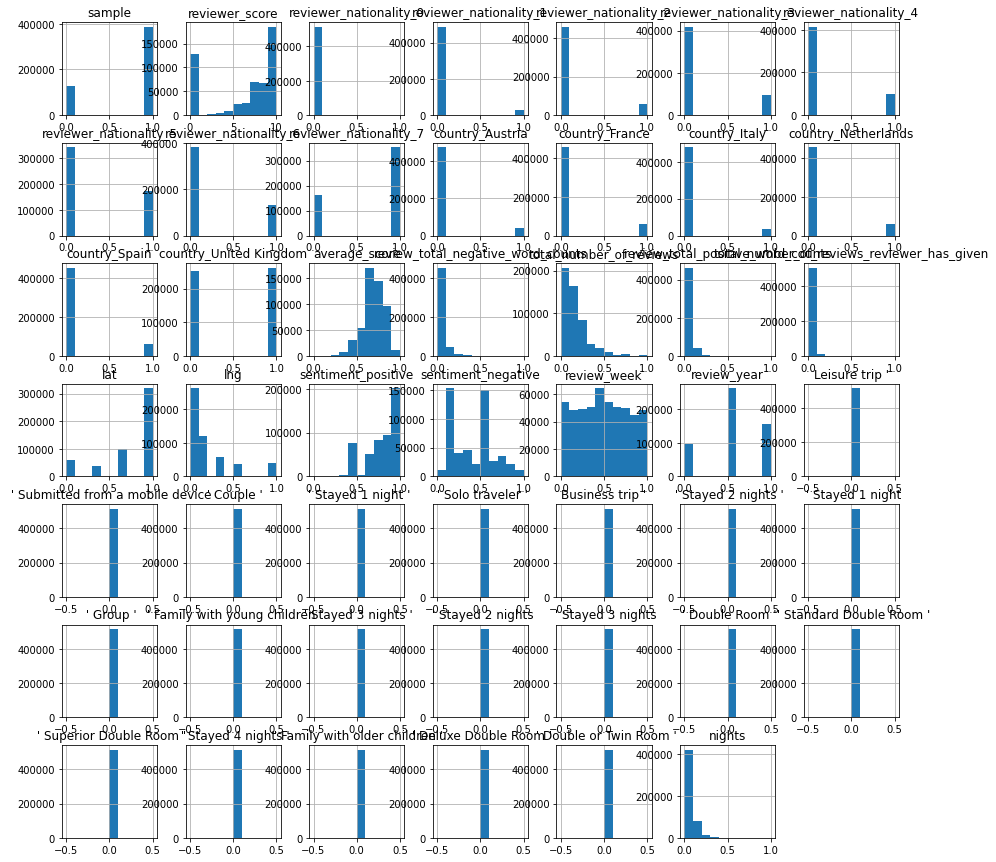

In [181]:
data.hist(figsize = (15,15))
plt.show()

In [183]:
 #plt.rcParams['figure.figsize'] = (15,10)
#sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [185]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [186]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [187]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 47), (386496, 47), (386496, 46), (309196, 46), (77300, 46))

In [188]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [189]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [190]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [191]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8784205657611035


<AxesSubplot:>

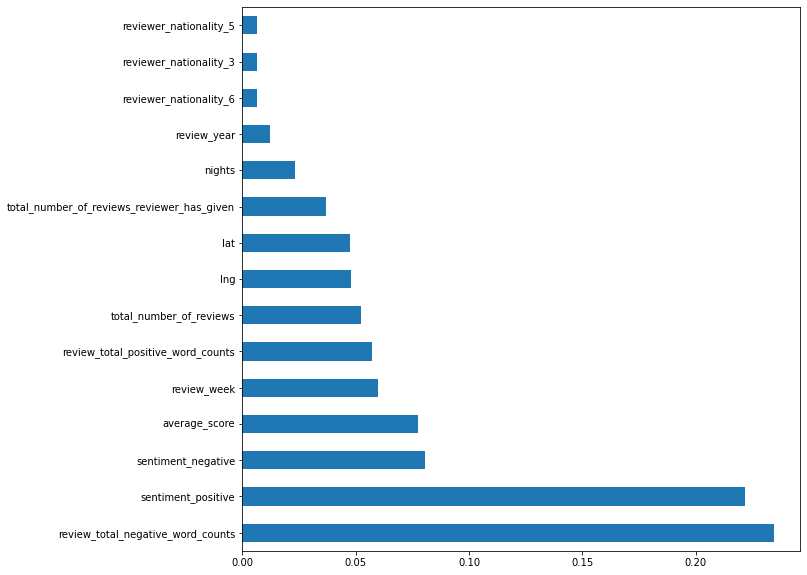

In [192]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [193]:
test_data.sample(10)

,reviewer_score,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,country_Austria,...,' Stayed 2 nights,' Stayed 3 nights,' Double Room ',' Standard Double Room ',' Superior Double Room ',' Stayed 4 nights ',' Family with older children ',' Deluxe Double Room ',' Double or Twin Room ',nights
114582,0.0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
98101,0.0,0,1,1,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667
49404,0.0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3760,0.0,0,0,0,0,0,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667
114018,0.0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333
119583,0.0,0,0,0,0,0,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333
63426,0.0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
124207,0.0,0,1,0,0,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333
42897,0.0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333
33696,0.0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [194]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [195]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [196]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.4s finished


In [197]:
predict_submission

array([8.71 , 7.134, 8.906, ..., 8.282, 9.512, 7.066])

In [198]:
list(sample_submission)

['reviewer_score', 'id']

In [199]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.710,488440
1,7.134,274649
2,8.906,374688
3,9.776,404352
4,9.768,451596
5,9.050,302161
6,8.022,317079
7,7.795,13963
8,8.702,159785
9,7.620,195089
